In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json


Matplotlib is building the font cache; this may take a moment.


In [ ]:
SCREEN_SIZE = (768, 1024)  # (height, width)

def plot_fixations_with_padded_image(
    fix_dict: dict,
    image_path: str,
    screen_size=SCREEN_SIZE,
    color_by: str = "order",
    point_size: float = 50,
    connect_path: bool = True,
    title: str | None = None,
):
    """
    Scale image to fit screen size with aspect ratio preserved, 
    pad it to exactly screen_size, then overlay fixations.
    Fixation coords are used as-is (assumed already in screen pixel space).
    """

    # --- Load original image ---
    img = Image.open(image_path).convert("RGB")
    orig_w, orig_h = img.size
    screen_h, screen_w = screen_size

    # --- Compute scaling (fit-to-screen, preserve aspect ratio) ---
    scale = min(screen_w / orig_w, screen_h / orig_h)
    new_w, new_h = int(orig_w * scale), int(orig_h * scale)
    img_resized = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

    # --- Pad to screen size (centered) ---
    padded = Image.new("RGB", (screen_w, screen_h), (0, 0, 0))  # black background
    pad_left = (screen_w - new_w) // 2
    pad_top = (screen_h - new_h) // 2
    padded.paste(img_resized, (pad_left, pad_top))

    # --- Fixation data (unchanged) ---
    xs = np.asarray(fix_dict["fix_x"], dtype=float)
    ys = np.asarray(fix_dict["fix_y"], dtype=float)
    durs = np.asarray(fix_dict.get("fix_dur_ms", [np.nan] * len(xs)), dtype=float)
    order = np.asarray(fix_dict.get("fix_index", np.arange(1, len(xs) + 1)), dtype=float)

    # Keep only fixations inside the screen
    mask = (xs >= 0) & (xs <= screen_w) & (ys >= 0) & (ys <= screen_h)
    xs, ys, durs, order = xs[mask], ys[mask], durs[mask], order[mask]

    if xs.size == 0:
        raise ValueError("No fixation points inside screen bounds.")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(screen_w/128, screen_h/128), dpi=128)

    ax.imshow(padded, extent=(0, screen_w, screen_h, 0))  # top-left origin

    # Scatter fixations
    if color_by.lower() in ("duration", "dur", "fix_dur_ms"):
        cvals, clabel, cmap = durs, "Fixation duration (ms)", "viridis"
    else:
        cvals, clabel, cmap = order, "Fixation order", "plasma"

    sc = ax.scatter(xs, ys, s=point_size, c=cvals, cmap=cmap,
                    edgecolor="white", linewidth=0.5, alpha=0.9)

    if connect_path and xs.size > 1:
        ax.plot(xs, ys, lw=1.5, alpha=0.7)

    cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label(clabel)

    ax.set_xlim(0, screen_w)
    ax.set_ylim(screen_h, 0)
    ax.set_title(title or f"Subject {fix_dict.get('subject_id','?')} • Trial {fix_dict.get('trial_index','?')}")
    ax.set_xlabel("x (screen px)")
    ax.set_ylabel("y (screen px)")

    plt.tight_layout()
    plt.show()


# Example usage:
# filtered = [trial for trial in data if trial["subject_id"] == "BR001"]



Found 40 trials for subject BR001


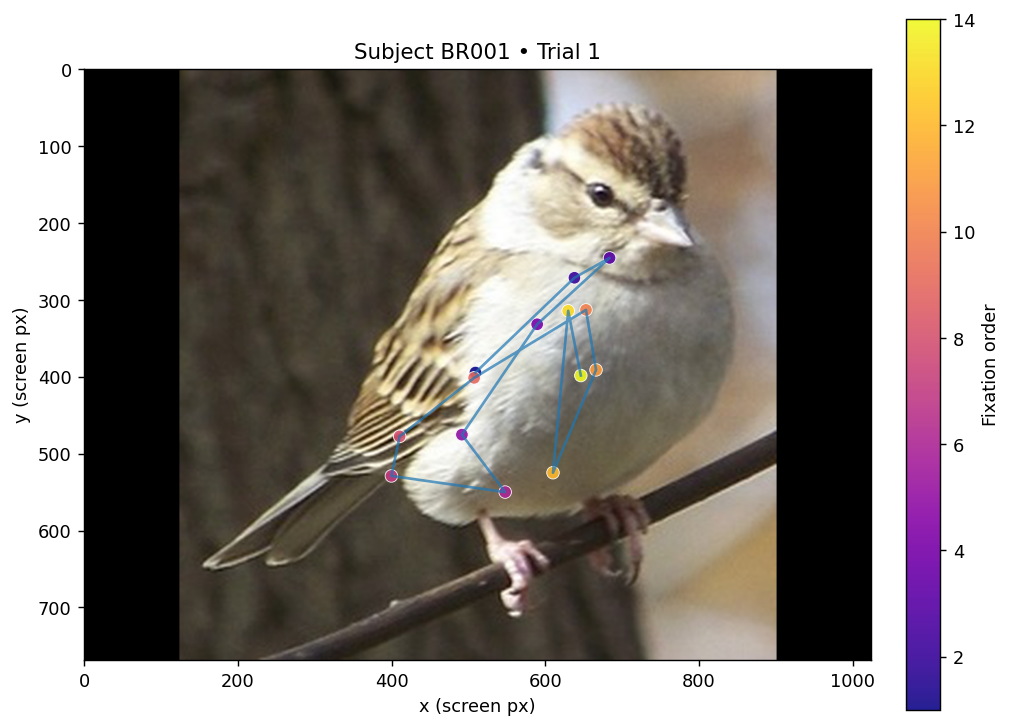

In [26]:
json_path = 'Training 1/Training1.json'

# Load JSON file (list of dictionaries)
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)   # this will be a list of dicts

# Filter by subject_id == "BR001"
filtered = [trial for trial in data if trial.get("subject_id") == "BR001"]


print(f"Found {len(filtered)} trials for subject BR001")

# fix_trial = filtered[0]
filename = "9deabceea18a435192804b8b54453422.jpg"

# SCREEN_SIZE = (768, 1024) # (h, w)

# plot_fixations(fix_trial , f"training1_images/{filename}", color_by="order")
# plot_fixations(fix_trial , f"training1_images/{filename}", color_by="duration")

plot_fixations_with_padded_image(filtered[0],  f"training1_images/{filename}", screen_size=SCREEN_SIZE)

